In [99]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from PredyNet_modules import *
import gym

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
env = gym.make("LunarLander-v2")
env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([-0.00189524,  0.93473321, -0.19198594, -0.39201806,  0.00220293,
        0.04348774,  0.        ,  0.        ])

In [3]:
action_space = env.action_space.n
obs_space = env.observation_space.shape[0]
ySize = 8


In [4]:
from PredyNet_modules import *

rec_model = action_LSTM(obs_space, action_space, 90)
yPrev = rec_model.init_hidden()

In [85]:
optimizer = torch.optim.SGD(rec_model.parameters(), lr=0.1)
criterion = nn.SmoothL1Loss()
criterion_act = nn.BCELoss()

In [86]:
act = env.action_space.sample()
observation = torch.Tensor(env.step(act)[0])

In [ ]:
timelength = 12000
Loss = np.zeros((timelength))
rX = np.zeros_like(Loss)
pX = np.zeros_like(rX)
Rew = np.zeros_like(rX)
act_vec = np.zeros((env.action_space.n, timelength))
ract_vec = np.zeros_like(act_vec)
rec = torch.zeros([obs_space])
env.reset()
act = env.action_space.sample()
act_tens = torch.eye(action_space)[act]
rloss = 0
for t in range(timelength):
    if np.random.rand() < 0.4:
        act = env.action_space.sample()
        act_tens = torch.eye(action_space)[act]

    obs_out = env.step(act)
    rew_out = torch.Tensor([obs_out[1]/100])
    obsies = torch.Tensor(obs_out[0])
#     observation = torch.cat((, obsies), 0)
    observation = obsies - rec.detach()
    done = obs_out[2]
    
    optimizer.zero_grad()
    
    model_input = torch.cat((observation, act_tens), 0)
    Rec, act_pred = rec_model(model_input)

    rec = Rec.squeeze()
    act_pred = act_pred.squeeze()
    
    loss = criterion(rec, observation)
    act_loss = criterion_act(act_pred, act_tens)
    
    rloss = obs_out[1] / 100
    loss.backward()
    act_loss.backward()
    optimizer.step()
    
    rX[t] = obs_out[0][0]
    pX[t] = rec.data.numpy()[0]    
    Loss[t] = loss.data.numpy()
    Rew[t] = obs_out[1]
    act_vec[:,t] = act_pred.data.numpy()
    ract_vec[:,t] = act_tens.data.numpy()
    
    if done:
        env.reset()

In [ ]:
timelength = 2000
Loss = np.zeros((timelength))
rX = np.zeros((obs_space, timelength))
pX = np.zeros_like(rX)
Rew = np.zeros_like(Loss)
act_vec = np.zeros((env.action_space.n, timelength))
ract_vec = np.zeros_like(act_vec)

env.reset()
act = env.action_space.sample()
act_tens = torch.eye(action_space)[act]
rloss = 0
t_cnt = 0
for t in range(timelength):
    if np.random.rand() < 0.2:
        act = env.action_space.sample()
        cnt = 1
        t_cnt = 0
        
    act_tens = torch.eye(action_space)[act]
    
    obs_out = env.step(act)
    rew_out = torch.Tensor([obs_out[1]/100])
    obsies = torch.Tensor(obs_out[0])
#     observation = torch.cat((rew_out, obsies), 0)
    if t_cnt <= 5 and cnt == 1:
        observation = obsies - rec.detach()
    else:
        observation = obsies
        t_cnt = 0
            
    done = obs_out[2]
    
    t_cnt += 1
    optimizer.zero_grad()
    
    model_input = torch.cat((observation, act_tens), 0)
    Rec, act_pred = rec_model(model_input)

    rec = Rec.squeeze()
    act_pred = act_pred.squeeze()
    
    loss = criterion(rec, observation)
    act_loss = criterion_act(act_pred, act_tens)
    
    rloss = obs_out[1] / 100
    
    rX[:,t] = observation.data.numpy()
    pX[:,t] = rec.data.numpy()   
    Loss[t] = loss.data.numpy()
    Rew[t] = obs_out[1]
    act_vec[:,t] = act_pred.data.numpy()
    ract_vec[:,t] = act_tens.data.numpy()
    
    
    if done:
        env.reset()
#         act = env.action_space.sample()

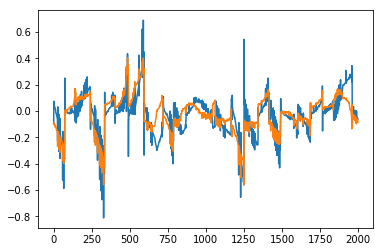

In [164]:
ind = 0
plt.plot(rX[ind,:])
plt.plot(pX[ind,:])

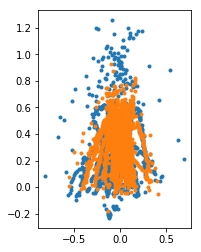

In [165]:
plt.subplot(1,2,1);
plt.plot(rX[0,:], rX[1,:],'.')
# plt.subplot(1,2,2);
plt.plot(pX[0,:], pX[1,:],'.');

## Note: running the system without error feedback (i.e. "dreaming") should require an error-like or other compensatory signal in the prediction to account for the offset.

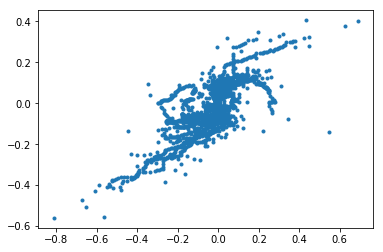

In [166]:
ind = 0
plt.plot(rX[ind,:], pX[ind,:],'.')

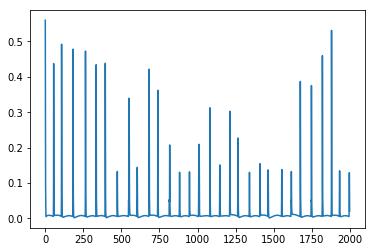

In [107]:
plt.plot(Loss)